Use shift-enter to execute a code block and move to the next one.

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7132479428120620315]

In [2]:
# 2.1 Import libraries.
import math
import os
import six
from six.moves import xrange  # pylint: disable=redefined-builtin
import numpy as np
import tensorflow as tf
# from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.contrib.learn.python.learn.datasets import mnist

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# 2.2 Define some constants.
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

# Batch size. Must be evenly dividable by dataset sizes.
BATCH_SIZE = 100
EVAL_BATCH_SIZE = 1

# Number of units in hidden layers.
HIDDEN1_UNITS = 128
HIDDEN2_UNITS = 32

# Maximum number of training steps.
MAX_STEPS = 2000

# Directory to put the training data.
TRAIN_DIR="/tmp/mnist"

In [4]:
if six.PY3:
    print('I am running Python 3!')
elif six.PY2:
    print('I am running Python 2!')
else:
    print('Python version uncertain...')

I am running Python 2!


In [5]:
# 2.3 Get input data: get the sets of images and labels for training, validation, and
# test on MNIST.
data_sets = mnist.read_data_sets(TRAIN_DIR, one_hot=False)

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


In [6]:
data_sets.train._labels

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

(array([ 165.,  212.,  287.,  374.,  426.,  571.,  692.,  733.,  812.,
         800.,  758.,  794.,  757.,  665.,  554.,  431.,  352.,  273.,
         197.,  147.]),
 array([ -1.99482095e+00,  -1.79516032e+00,  -1.59549969e+00,
         -1.39583907e+00,  -1.19617844e+00,  -9.96517807e-01,
         -7.96857178e-01,  -5.97196549e-01,  -3.97535920e-01,
         -1.97875291e-01,   1.78533792e-03,   2.01445967e-01,
          4.01106596e-01,   6.00767225e-01,   8.00427854e-01,
          1.00008848e+00,   1.19974911e+00,   1.39940974e+00,
          1.59907037e+00,   1.79873100e+00,   1.99839163e+00]),
 <a list of 20 Patch objects>)

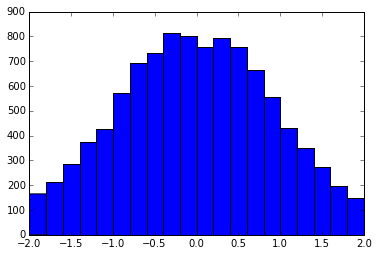

In [7]:
# truncated_normal discard values beyond 2\sigma and resamples
a = tf.truncated_normal([10000, 1])
b = tf.Session().run(a)
plt.hist(b, bins=20)

In [6]:
# 2.4 Build inference graph.
def mnist_inference(images, hidden1_units, hidden2_units):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
        hidden2_units: Size of the second hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """
    # Hidden 1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
                                stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))), # why normalize?
            name='weights')
        biases = tf.Variable(tf.zeros([hidden1_units]),
                             name='biases')
        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
    # Hidden 2
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1_units, hidden2_units],
                                stddev=1.0 / math.sqrt(float(hidden1_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden2_units]),
                             name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2_units, NUM_CLASSES],
                                stddev=1.0 / math.sqrt(float(hidden2_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([NUM_CLASSES]),
                             name='biases')
        logits = tf.matmul(hidden2, weights) + biases

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "inference.pbtxt", as_text=True)
    return logits

In [7]:
# 2.5 Build training graph.
def mnist_training(logits, labels, learning_rate):
    """Build the training graph.

    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
          range [0, NUM_CLASSES).
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
        loss: The Op for calculating loss.
    """
    # Create an operation that calculates loss.
    labels = tf.to_int64(labels)
    # tf.nn.softmax_cross_entropy_with_logits() works with one-hot encoding
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "train.pbtxt", as_text=True)

    return train_op, loss

In [9]:
images_placeholder = tf.placeholder(tf.float32)                                       
logits = mnist_inference(images_placeholder,
                             HIDDEN1_UNITS,
                             HIDDEN2_UNITS)

In [15]:
for x in tf.trainable_variables():
    print(x._variable)

Tensor("hidden1/weights:0", shape=(784, 128), dtype=float32_ref)
Tensor("hidden1/biases:0", shape=(128,), dtype=float32_ref)
Tensor("hidden2/weights:0", shape=(128, 32), dtype=float32_ref)
Tensor("hidden2/biases:0", shape=(32,), dtype=float32_ref)
Tensor("softmax_linear/weights:0", shape=(32, 10), dtype=float32_ref)
Tensor("softmax_linear/biases:0", shape=(10,), dtype=float32_ref)


In [10]:
# 2.6 Build the complete graph for feeding inputs, training, and saving checkpoints.
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    # Generate placeholders for the images and labels.
    images_placeholder = tf.placeholder(tf.float32)                                       
    labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection("images", images_placeholder)  # Remember this Op.
    tf.add_to_collection("labels", labels_placeholder)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    logits = mnist_inference(images_placeholder,
                             HIDDEN1_UNITS,
                             HIDDEN2_UNITS)
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, loss = mnist_training(logits, labels_placeholder, 0.01)

    # Add the variable initializer Op.
    init = tf.global_variables_initializer()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    
    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "complete.pbtxt", as_text=True)

In [11]:
# 2.7 Run training for MAX_STEPS and save checkpoint at the end.
losses = []
with tf.Session(graph=mnist_graph) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)
    
    # Start the training loop.
    for step in xrange(MAX_STEPS):
        # Read a batch of images and labels.
        images_feed, labels_feed = data_sets.train.next_batch(BATCH_SIZE)

        # Run one step of the model.  The return values are the activations
        # from the `train_op` (which is discarded) and the `loss` Op.  To
        # inspect the values of your Ops or variables, you may include them
        # in the list passed to sess.run() and the value tensors will be
        # returned in the tuple from the call.
        _, loss_value = sess.run([train_op, loss],
                                 feed_dict={images_placeholder: images_feed,
                                            labels_placeholder: labels_feed})
        losses.append(loss_value)
        # Print out loss value.
        if step % 200 == 0:
            print('Step %d: loss = %.2f' % (step, loss_value))

    # Write a checkpoint.
    checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)

Step 0: loss = 2.30
Step 200: loss = 1.90
Step 400: loss = 1.34
Step 600: loss = 0.86
Step 800: loss = 0.72
Step 1000: loss = 0.51
Step 1200: loss = 0.54
Step 1400: loss = 0.57
Step 1600: loss = 0.45
Step 1800: loss = 0.39


In [13]:
tf.trainable_variables()

[]

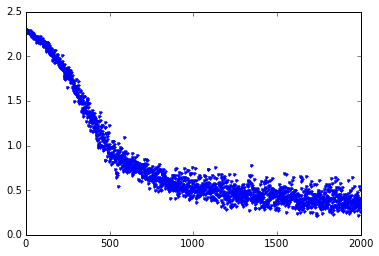

In [12]:
plt.plot(losses, '.')a

In [ ]:
# 2.8 Run evaluation based on the saved checkpoint.
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint-1999.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint-1999"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    images_feed, labels_feed = data_sets.validation.next_batch(EVAL_BATCH_SIZE)
    imgplot = plt.imshow(np.reshape(images_feed, (28, 28)))
    prediction = sess.run(eval_op,
                          feed_dict={images_placeholder: images_feed,
                                     labels_placeholder: labels_feed})
    print("Ground truth: %d\nPrediction: %d" % (labels_feed, prediction.indices[0][0]))

<p>Back to [1_linear_regression_model.ipynb](1_linear_regression_model.ipynb).</p>
<p>Next to [Bonus Lab](extras/extras_0_deepdream.ipynb).</p>

In [1]:
from tensorflow.contrib.learn.python.learn.datasets import mnist
from tensorflow.python.client import device_lib
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import os

%matplotlib inline
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15344444729063870676]

In [2]:
TRAIN_DIR = r'/tmp/mnist/'
datasets = mnist.read_data_sets(TRAIN_DIR, one_hot=True)


Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
# constants 
n_hidden1 = 128
n_hidden2 = 32
imagesize = 784
n_class = 10
n_max_train = 2000
n_batch = 100

In [4]:
tf.reset_default_graph()

In [5]:
[x._variable for x in tf.trainable_variables()]

[]

In [6]:
def mnist_inference(image_data):
    
    # hidden_1
    with tf.name_scope('hidden_1'):
        weights_1 = tf.Variable(
            tf.truncated_normal([imagesize, n_hidden1],
                                stddev=1.0 / (float(imagesize) ** 0.5)), 
                                name='weights_1'
        )
        biases_1 = tf.Variable(
            tf.zeros([n_hidden1]), name='biases_1'
        )
        hidden_1 = tf.nn.relu(tf.matmul(image_data, weights_1) + biases_1, name='hidden_1')
    
    # hidden_2
    with tf.name_scope('hidden_2'):
        weights_2 = tf.Variable(
            tf.truncated_normal([n_hidden1, n_hidden2],
                                stddev=1.0 / (float(n_hidden1) ** 0.5)), 
                                name='weights_2'
        )
        biases_2 = tf.Variable(
            tf.zeros([n_hidden2]), name='biases_2'
        )
        hidden_2 = tf.nn.relu(tf.matmul(hidden_1, weights_2) + biases_2, name='hidden_2')
    
    # softmax
    with tf.name_scope('softmax'):
        weights_3 = tf.Variable(
            tf.truncated_normal([n_hidden2, n_class],
                                stddev=1.0 / (float(n_hidden2) ** 0.5)), 
                                name='weights_3'
        )
        biases_3 = tf.Variable(
            tf.zeros([n_class]), name='biases_3'
        )
        logits = tf.matmul(hidden_2, weights_3) + biases_3
    
    return logits


def mnist_train(logits, label_data, learning_rate=0.05):
    
    # build losses
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=label_data, logits=logits),
        name='loss'
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op, loss



In [ ]:
tf.reset_default_graph()
    
# run training op
image_placeholder = tf.placeholder(tf.float32, shape=(None, imagesize), name='image_placeholder')
label_placeholder = tf.placeholder(tf.int32, shape=(None, 10), name='label_placeholder')
logits = mnist_inference(image_placeholder)

tf.add_to_collection("images", image_placeholder)  # Remember this Op.
tf.add_to_collection("labels", label_placeholder)  # Remember this Op.
tf.add_to_collection("logits", logits)  # Remember this Op.

train_op, loss = mnist_train(logits, label_placeholder, learning_rate=0.01)
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

losses = []

with tf.Session() as sess:
    sess.run(init_op)
    
    for i_train in xrange(n_max_train):
#         image_feed, label_feed = datasets.train.next_batch(n_batch)
        image_feed_tensor, label_feed_tensor = tf.train.batch([datasets.train._images, datasets.train._labels],
                                                batch_size=n_batch,
                                                enqueue_many=True)
        image_feed, label_feed = sess.run([image_feed_tensor, label_feed_tensor])
    
        _, t_loss = sess.run([train_op, loss], 
                             feed_dict={image_placeholder:image_feed,
                                       label_placeholder:label_feed})
        losses.append(t_loss)

        if i_train % 500 == 0:
            print('Iteration {}, loss {}'.format(i_train, t_loss))
        if i_train % 600 == 0:
            # Write a checkpoint.
            checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint_{:d}.ckpt'.format(i_train))
            saver.save(sess, checkpoint_file)


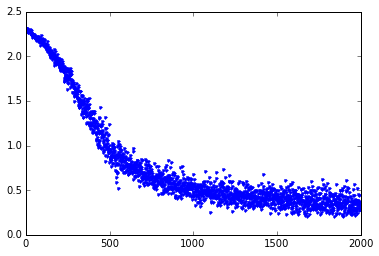

In [66]:
plt.plot(losses, '.')
# plt.ylim([0, 10])

Ground truth: 4
Prediction: 4


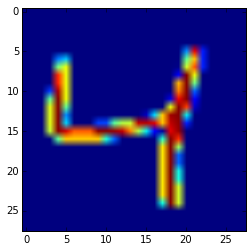

In [69]:
# new_graph = tf.Graph()
# with tf.Session(graph=new_graph) as sess:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(TRAIN_DIR, "checkpoint_1800.ckpt.meta"))
    saver.restore(
        sess, os.path.join(TRAIN_DIR, "checkpoint_1800.ckpt"))

    # Retrieve the Ops we 'remembered'.
#     logits = tf.get_collection("logits")[0]
#     image_placeholder = tf.get_collection("images")[0]
#     label_placeholder = tf.get_collection("labels")[0]

    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    images_feed, labels_feed = datasets.validation.next_batch(1)
    imgplot = plt.imshow(np.reshape(images_feed, (28, 28)))
    prediction = sess.run(eval_op,
                          feed_dict={image_placeholder: images_feed,
                                     label_placeholder: labels_feed})
    print("Ground truth: {}\nPrediction: {}".format(
            np.argmax(labels_feed), prediction.indices[0][0]))

In [34]:
prediction.indices

array([[5]], dtype=int32)

In [72]:
tf.reset_default_graph()

### Questions：

1. Why do we have to normalize the stddev parameter during intitialization?
2. What does `import_meta_graph` and `restore` do?
3. What does `add_to_collection` and `get_collection` do?

### Tips:
- Remember to use `tf.reset_default_graph()` before training

In [44]:
import tensorflow as tf

def save(checkpoint_file='/tmp/mnist/hello.chk'):
    with tf.Session() as session:
        x = tf.Variable([42.0, 42.1, 42.3], name='x')
        y = tf.Variable([[1.0, 2.0], [3.0, 4.0]], name='y')
        not_saved = tf.Variable([-1, -2], name='not_saved')
        session.run(tf.global_variables_initializer())

        print(session.run(tf.global_variables()))
#         saver = tf.train.Saver([x, y])
        saver = tf.train.Saver()
        saver.save(session, checkpoint_file)

def restore(checkpoint_file='/tmp/mnist/hello.chk'):
    # have to rebuild 
    x = tf.Variable(-1.0, validate_shape=False, name='x')
    y = tf.Variable(-1.0, validate_shape=False, name='y')
    
    with tf.Session() as session:
        saver = tf.train.Saver()
        saver.restore(session, checkpoint_file)
        print(session.run(tf.global_variables()))

def restore2(checkpoint_file='/tmp/mnist/hello.chk'):
    with tf.Session() as session:
        saver = tf.train.import_meta_graph(checkpoint_file + ".meta")
        saver.restore(session, checkpoint_file)
        session.run(tf.global_variables_initializer()) #needed
        print(session.run(tf.global_variables()))

        
def reset():
    tf.reset_default_graph()
    
save() # saves [x, y, not_saved]
reset()
restore() # loads [x, y]
reset()
restore2() # loads [x, y, not_saved]

[-1.0, -1.0, -1.0, array([ 42.        ,  42.09999847,  42.29999924], dtype=float32), array([[ 1.,  2.],
       [ 3.,  4.]], dtype=float32), array([-1, -2], dtype=int32)]
[-1.0, -1.0]
[-1.0, -1.0, -1.0, array([ 42.        ,  42.09999847,  42.29999924], dtype=float32), array([[ 1.,  2.],
       [ 3.,  4.]], dtype=float32), array([-1, -2], dtype=int32)]


In [51]:
tf.get_default_graph().as_graph_def()

node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_STRING
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_STRING
        tensor_shape {
        }
        string_val: "hello"
      }
    }
  }
}
versions {
  producer: 21
}

In [36]:
tf.reset_default_graph()

In [34]:
[x._variable for x in tf.global_variables()]

[<tf.Tensor 'x:0' shape=(3,) dtype=float32_ref>,
 <tf.Tensor 'y:0' shape=(2, 2) dtype=float32_ref>,
 <tf.Tensor 'not_saved:0' shape=(2,) dtype=int32_ref>]

In [21]:
restore()

[-1.0, -1.0, -1.0]


# Visualize graph in iPython notbook


In [41]:
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [100]:
show_graph(tf.get_default_graph().as_graph_def())

In [74]:
a = tf.constant('hello')
tf.Session().run(a)

'hello'

In [97]:
tf.reset_default_graph()

In [99]:

with tf.Session() as session:
    x = tf.Variable([42.0, 42.1, 42.3], name='x')
    a = tf.constant('hello', name='a')
    b = tf.placeholder(tf.float16, name='b')
    session.run(tf.global_variables_initializer())
    print(session.run(tf.global_variables()))

[array([ 42.        ,  42.09999847,  42.29999924], dtype=float32)]


In [57]:
save()

[array([ 42.        ,  42.09999847,  42.29999924], dtype=float32), array([[ 1.,  2.],
       [ 3.,  4.]], dtype=float32), array([-1, -2], dtype=int32)]


In [5]:
a

array([1, 2, 3])

In [6]:
a = np.array([4, 5, 6]).reshape((3, 1))
# b = np.array([4, 5, 6])
a_batch = tf.train.batch([a], 
                         batch_size=2,
                         enqueue_many=True)

In [7]:
a_batch

<tf.Tensor 'batch_1:0' shape=(2, 1) dtype=int64>

In [ ]:
with tf.Session() as sess:
    print(sess.run(tf.convert_to_tensor(a_batch.get_shape())))
    print(sess.run(a_batch))

In [1]:
import tensorflow as tf
import numpy as np